In [2]:
import pandas as pd

# Load the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge transactions with product data to get the category for each product
merged_data = pd.merge(transactions, products[['ProductID', 'Category']], on='ProductID', how='left')

# Group by CustomerID and Category, and count the frequency of each category per customer
category_data = merged_data.groupby(['CustomerID', 'Category']).size().unstack(fill_value=0)

# Calculate the total spent and the number of transactions for each customer
total_spent = merged_data.groupby('CustomerID')['TotalValue'].sum()
num_transactions = merged_data.groupby('CustomerID').size()

# Merge category data, total spent, and transaction count with customer profile data
customer_data = pd.merge(customers[['CustomerID', 'Region', 'SignupDate']], category_data, on='CustomerID', how='left')
customer_data = pd.merge(customer_data, total_spent, on='CustomerID', how='left')
customer_data = pd.merge(customer_data, num_transactions.rename("Number_of_Transactions"), on='CustomerID', how='left')

# Add a mapping of Category columns to retain clarity
category_mapping = {col: f"Category_{col}" for col in category_data.columns}
customer_data.rename(columns=category_mapping, inplace=True)

# Display the final customer data
print(customer_data.head())


  CustomerID         Region  SignupDate  Category_Books  Category_Clothing  \
0      C0001  South America  2022-07-10             1.0                0.0   
1      C0002           Asia  2022-02-13             0.0                2.0   
2      C0003  South America  2024-03-07             0.0                1.0   
3      C0004  South America  2022-10-09             3.0                0.0   
4      C0005           Asia  2022-08-15             0.0                0.0   

   Category_Electronics  Category_Home Decor  TotalValue  \
0                   3.0                  1.0     3354.52   
1                   0.0                  2.0     1862.74   
2                   1.0                  2.0     2725.38   
3                   2.0                  3.0     5354.88   
4                   2.0                  1.0     2034.24   

   Number_of_Transactions  
0                     5.0  
1                     4.0  
2                     4.0  
3                     8.0  
4                     3.0  


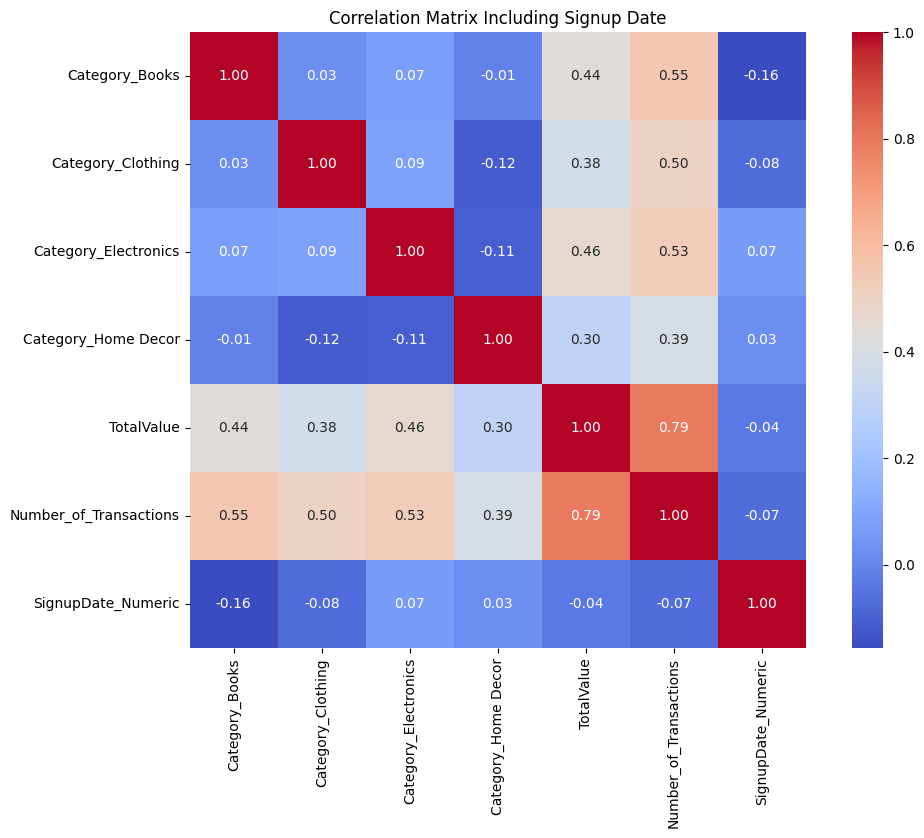

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert SignupDate to datetime format
customer_data['SignupDate'] = pd.to_datetime(customer_data['SignupDate'])

# Create a numeric version of SignupDate (e.g., days since the earliest signup)
customer_data['SignupDate_Numeric'] = (customer_data['SignupDate'] - customer_data['SignupDate'].min()).dt.days

# Select numeric columns for correlation matrix
numeric_columns = customer_data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = customer_data[numeric_columns].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix Including Signup Date")
plt.show()


In [4]:
print(customer_data.head())

  CustomerID         Region SignupDate  Category_Books  Category_Clothing  \
0      C0001  South America 2022-07-10             1.0                0.0   
1      C0002           Asia 2022-02-13             0.0                2.0   
2      C0003  South America 2024-03-07             0.0                1.0   
3      C0004  South America 2022-10-09             3.0                0.0   
4      C0005           Asia 2022-08-15             0.0                0.0   

   Category_Electronics  Category_Home Decor  TotalValue  \
0                   3.0                  1.0     3354.52   
1                   0.0                  2.0     1862.74   
2                   1.0                  2.0     2725.38   
3                   2.0                  3.0     5354.88   
4                   2.0                  1.0     2034.24   

   Number_of_Transactions  SignupDate_Numeric  
0                     5.0                 169  
1                     4.0                  22  
2                     4.0       

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import pandas as pd

label_encoder = LabelEncoder()
customer_data['Region_Encoded'] = label_encoder.fit_transform(customer_data['Region'])


features = customer_data[['Category_Books', 'Category_Clothing', 'Category_Electronics'
                        ]]


In [20]:

print(customer_data.head())


  CustomerID         Region SignupDate  Category_Books  Category_Clothing  \
0      C0001  South America 2022-07-10             1.0                0.0   
1      C0002           Asia 2022-02-13             0.0                2.0   
2      C0003  South America 2024-03-07             0.0                1.0   
3      C0004  South America 2022-10-09             3.0                0.0   
4      C0005           Asia 2022-08-15             0.0                0.0   

   Category_Electronics  Category_Home Decor  TotalValue  \
0                   3.0                  1.0     3354.52   
1                   0.0                  2.0     1862.74   
2                   1.0                  2.0     2725.38   
3                   2.0                  3.0     5354.88   
4                   2.0                  1.0     2034.24   

   Number_of_Transactions  SignupDate_Numeric  Region_Encoded  Cluster  \
0                     5.0                 169               3        9   
1                     4.0   

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import pandas as pd



# Select relevant features, excluding correlated ones
features = customer_data[['Category_Books', 'Category_Clothing',
                           'Category_Electronics', 'Category_Home Decor','TotalValue',
                          'Number_of_Transactions', 'Region_Encoded']]

# Select relevant features for clustering
# features = customer_data[['Category_Electronics',

#                      'Region_Encoded']]


# Step 1: Handle missing values (impute missing values)
imputer = SimpleImputer(strategy='median')  # or use 'mean' based on your preference
features_imputed = imputer.fit_transform(features)

# Step 2: Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)
for i in range(2, 11):
  print(i,"\n")
# Step 3: Apply KMeans clustering
  kmeans = KMeans(n_clusters=i, random_state=42)
  clusters = kmeans.fit_predict(features_scaled)

  # Step 4: Ensure the correct index is used (DB index values)
  customer_data['Cluster'] = pd.Series(clusters, index=customer_data.index)

  # Step 5: Calculate the Davies-Bouldin Index (DBI)
  dbi = davies_bouldin_score(features_scaled, clusters)
  print(f'Davies-Bouldin Index: {dbi}')



2 

Davies-Bouldin Index: 1.6330630717068264
3 

Davies-Bouldin Index: 1.8621478360973371
4 

Davies-Bouldin Index: 1.6594631210181854
5 

Davies-Bouldin Index: 1.6539623608107594
6 

Davies-Bouldin Index: 1.724719683081328
7 

Davies-Bouldin Index: 1.484977929219313
8 

Davies-Bouldin Index: 1.647527754956325
9 

Davies-Bouldin Index: 1.6060224145070203
10 

Davies-Bouldin Index: 1.5659324151190848


In [17]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import pandas as pd



# # Select relevant features, excluding correlated ones
# features = customer_data[['Category_Books', 'Category_Clothing',
#                            'Category_Electronics', 'Category_Home Decor','TotalValue'
#                           'Number_of_Transactions', 'Region_Encoded']]

# Select relevant features for clustering
features = customer_data[['Category_Electronics',

                     'Region_Encoded']]


# Step 1: Handle missing values (impute missing values)
imputer = SimpleImputer(strategy='median')  # or use 'mean' based on your preference
features_imputed = imputer.fit_transform(features)

# Step 2: Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)
for i in range(2, 11):
  print(i,"\n")
# Step 3: Apply KMeans clustering
  kmeans = KMeans(n_clusters=i, random_state=42)
  clusters = kmeans.fit_predict(features_scaled)

  # Step 4: Ensure the correct index is used (DB index values)
  customer_data['Cluster'] = pd.Series(clusters, index=customer_data.index)

  # Step 5: Calculate the Davies-Bouldin Index (DBI)
  dbi = davies_bouldin_score(features_scaled, clusters)
  print(f'Davies-Bouldin Index: {dbi}')



2 

Davies-Bouldin Index: 1.2078442388227058
3 

Davies-Bouldin Index: 0.8865209261050625
4 

Davies-Bouldin Index: 0.7605321212283834
5 

Davies-Bouldin Index: 0.7884060763113168
6 

Davies-Bouldin Index: 0.8558837477374106
7 

Davies-Bouldin Index: 0.7357127288860363
8 

Davies-Bouldin Index: 0.8153860564044897
9 

Davies-Bouldin Index: 0.6452701453310218
10 

Davies-Bouldin Index: 0.6121422617260179


# **WHY?**

#Due to strong co-relation between 'Category_Books', 'Category_Clothing',
#                            'Category_Electronics', 'Category_Home Decor', even in 'TotalValue'
#                           'Number_of_Transactions',

so even if we select any of these and drop others we see better clustering.

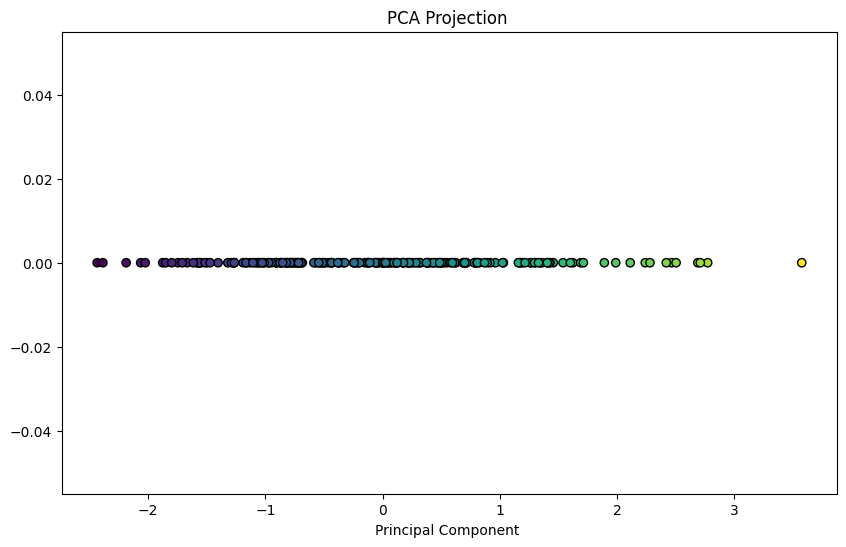

Explained Variance Ratio (PCA): [0.20647197]
Total Variance Retained by PCA: 0.2064719746544804

--- Final Cluster Assignments ---
   Category_Books  Category_Clothing  Category_Electronics  \
0             1.0                0.0                   3.0   
1             0.0                2.0                   0.0   
2             0.0                1.0                   1.0   
3             3.0                0.0                   2.0   
4             0.0                0.0                   2.0   

   Category_Home Decor  Avg_Transaction_Value  Cluster  
0                  1.0                670.904        0  
1                  2.0                465.685        2  
2                  2.0                681.345        1  
3                  3.0                669.360        4  
4                  1.0                678.080        1  
Davies-Bouldin Index (with PCA): 0.49632641488549945


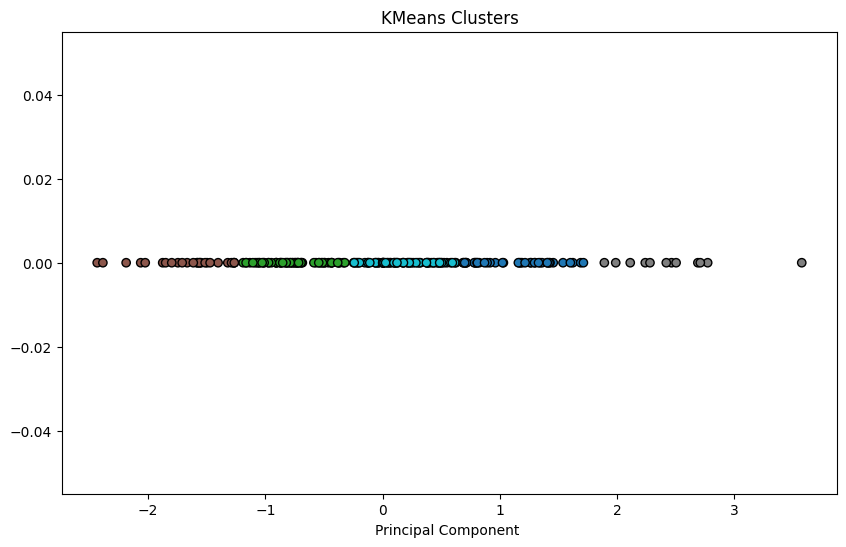

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd

# Handle divide-by-zero cases cleanly
customer_data["Avg_Transaction_Value"] = customer_data["TotalValue"] / customer_data["Number_of_Transactions"]
customer_data["Avg_Transaction_Value"] = customer_data["Avg_Transaction_Value"].fillna(0)

# Select relevant features, excluding correlated ones
features = customer_data[['Category_Books', 'Category_Clothing',
                           'Category_Electronics', 'Category_Home Decor',
                           'Avg_Transaction_Value', 'Region_Encoded']]

# Handle missing values
imputer = SimpleImputer(strategy='median')
features_imputed = imputer.fit_transform(features)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Apply PCA
pca = PCA(n_components=1)
features_pca = pca.fit_transform(features_scaled)

# Plot PCA 1 component
plt.figure(figsize=(10, 6))
plt.scatter(features_pca, [0] * len(features_pca), c=features_pca, cmap='viridis', edgecolor='k')
plt.title("PCA Projection ")
plt.xlabel("Principal Component ")
plt.show()

print(f"Explained Variance Ratio (PCA): {pca.explained_variance_ratio_}")
print(f"Total Variance Retained by PCA: {pca.explained_variance_ratio_.sum()}\n")

# Final cluster assignment
customer_data['Cluster'] = clusters
print("--- Final Cluster Assignments ---")
print(customer_data[['Category_Books', 'Category_Clothing',
                     'Category_Electronics', 'Category_Home Decor',
                     'Avg_Transaction_Value', 'Cluster']].head())


plt.show()
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(features_pca)

# Calculate Davies-Bouldin Index (DBI)
dbi = davies_bouldin_score(features_pca, clusters)
print(f"Davies-Bouldin Index (with PCA): {dbi}")


# Plot clustering results for current number of clusters
plt.figure(figsize=(10, 6))
plt.scatter(features_pca, [0] * len(features_pca), c=clusters, cmap='tab10', edgecolor='k')
plt.title(f"KMeans Clusters")
plt.xlabel("Principal Component ")
plt.show()



Davies-Bouldin Index (with PCA): 0.49632641488549945
--- Final Cluster Assignments ---
   Category_Books  Category_Clothing  Category_Electronics  \
0             1.0                0.0                   3.0   
1             0.0                2.0                   0.0   
2             0.0                1.0                   1.0   
3             3.0                0.0                   2.0   
4             0.0                0.0                   2.0   
5             2.0                1.0                   0.0   
6             0.0                0.0                   2.0   
7             1.0                2.0                   3.0   
8             0.0                2.0                   1.0   
9             1.0                3.0                   0.0   

   Category_Home Decor  Avg_Transaction_Value  Cluster  
0                  1.0             670.904000        0  
1                  2.0             465.685000        2  
2                  2.0             681.345000        1  
3 

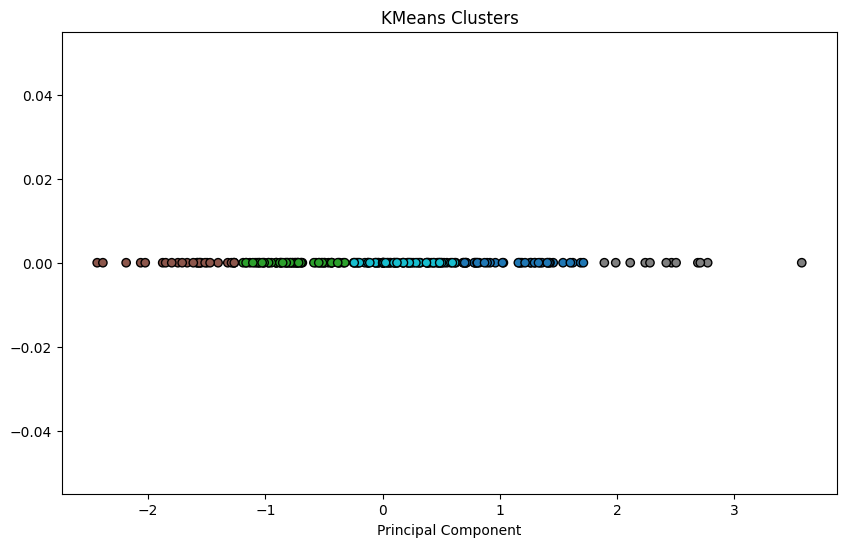

CSV file 'customer_data_with_clusters.csv' has been saved.


In [25]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(features_pca)

# Calculate Davies-Bouldin Index (DBI) for 5 clusters
dbi = davies_bouldin_score(features_pca, clusters)
print(f"Davies-Bouldin Index (with PCA): {dbi}")

# Add cluster information to customer_data DataFrame
customer_data['Cluster'] = clusters

# Print the top 10 rows of the customer data with cluster assignment
print("--- Final Cluster Assignments ---")
print(customer_data[['Category_Books', 'Category_Clothing',
                     'Category_Electronics', 'Category_Home Decor',
                     'Avg_Transaction_Value', 'Cluster']].head(10))

# Save the DataFrame with the cluster assignments to a CSV file
customer_data.to_csv('customer_data_with_clusters.csv', index=False)

# Plot clustering results
plt.figure(figsize=(10, 6))
plt.scatter(features_pca, [0] * len(features_pca), c=clusters, cmap='tab10', edgecolor='k')
plt.title("KMeans Clusters")
plt.xlabel("Principal Component")
plt.show()

# Confirmation message
print("CSV file 'customer_data_with_clusters.csv' has been saved.")